In [54]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial.distance import pdist

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
sns.set_style('white')

In [55]:
path = Path('data', 'bbc')
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]]).strip()
    doc_list.append([topic, heading, body])

In [56]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   body     2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [57]:
docs.sample(5)

,topic,heading,body
867,entertainment,Film star Fox behind theatre bid,Leading actor Edward Fox is one of the men beh...
40,business,Fed chief warning on US deficit,Federal Reserve chairman Alan Greenspan has wa...
209,business,Gold falls on IMF sale concerns,The price of gold has fallen after the Interna...
1522,sport,Tevez - an Argentine in Brazil,Some 65 years ago Bernardo Gandulla left Boca ...
1189,politics,Civil servants in strike ballot,The UK's biggest civil service union is to bal...


In [58]:
docs.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})

,count
sport,22.97%
business,22.92%
politics,18.74%
tech,18.02%
entertainment,17.35%


In [59]:
#word count
word_count = docs.body.str.split().str.len().sum()
print(f'Total word cnt: {word_count:,d} | per article: {word_count/len(docs):,.0f}')

Total word cnt: 842,910 | per article: 379


In [60]:
token_count = Counter()
for i, doc in enumerate(docs.body.tolist(), 1):
    if i%1000 == 0:
        print(i, end=' ', flush=True)
    token_count.update([t.strip() for t in doc.split()])

1000 2000 

tockens: token
the     44432
to      24460
of      19756
and     17867
a       17115
in      16316
is       8427
for      8424
that     7528
The      7182
Name: count, dtype: int64


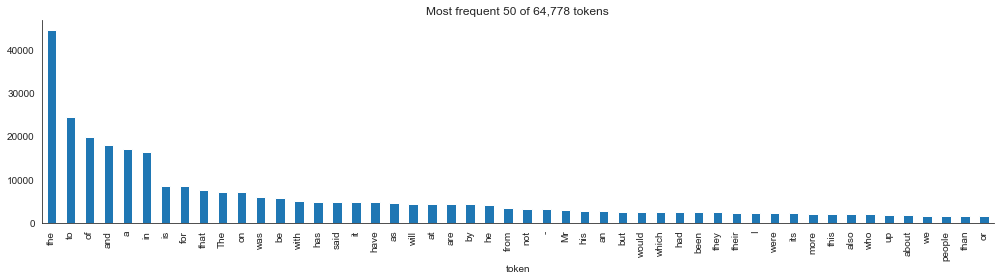

In [61]:
tokens = (pd.DataFrame(token_count.most_common(), columns=['token', 'count']).set_index('token').squeeze())
print(f'tockens: {tokens[:10]}')

n = 50
(tokens.iloc[:50].plot.bar(figsize=(14, 4), title=f'Most frequent {n} of {len(tokens):,d} tokens'))
sns.despine()
plt.tight_layout();

In [62]:
# Document Frequency Distribution
# max_df - to remove word that appears too frequently on documents
binary_vectorizer = CountVectorizer(max_df=1.0, min_df=1, binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs.body)
binary_dtm

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [63]:
n_docs, n_tokens = binary_dtm.shape
tokens_dtm = binary_vectorizer.get_feature_names()
tokens.index.difference(pd.Index(tokens_dtm))

Index(['!', '"', '""unconscionable,', '"'I', '"'Oh', '"'We', '"'You', '"(When',
       '"...it', '"100%',
       ...
       'Â£900m', 'Â£910m).', 'Â£93.6bn)', 'Â£933m', 'Â£947m', 'Â£960m',
       'Â£98)', 'Â£99', 'Â£9m', 'Â£9m,'],
      dtype='object', length=47927)

In [64]:
results_path = Path('results', 'bbc')
if not results_path.exists():
    results_path.mkdir(parents=True)

dtm_path = results_path / 'binary_dtm.npz'
if not dtm_path.exists():
    sparse.save_npz(dtm_path, binary_dtm)

token_path = results_path / 'tokens.csv'
if not token_path.exists():
    pd.Series(tokens_dtm).to_csv(token_path, index=False)
else:
    tokens = pd.read_csv(token_path, header=None, squeeze=True)

doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(n_docs)
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [65]:
df_range = FloatRangeSlider(value=[0.0, 1.0], min=0, max=1, step=0.0001, description='Doc. Freq.',
                            disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                            readout_format='.1%', layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
    axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

In [66]:
m = binary_dtm.todense()
pairwise_distances = pdist(m, metric='cosine')
closest = np.argmin(pairwise_distances)
rows, cols = np.triu_indices(n_docs)
rows[closest], cols[closest]

(6, 245)

In [67]:
docs.iloc[6].to_frame(6).join(docs.iloc[245].to_frame(245)).to_csv(results_path / 'most_similar.csv')
docs.iloc[6]

topic                                               business
heading                     Jobs growth still slow in the US
body       The US created fewer jobs than expected in Jan...
Name: 6, dtype: object

In [68]:
pd.DataFrame(binary_dtm[[6, 245], :].todense()).sum(0).value_counts()

0    28972
1      265
2       38
dtype: int64

In [69]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [70]:
doc_term_matrix.shape

(2225, 29275)

In [71]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

In [72]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.DataFrame.sparse.from_spmatrix(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Most frequent terms
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head()

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int32

In [74]:
# Compute relative term frequency
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 29275)

In [75]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(docs.shape[0]).sort_values(ascending=False).head(10)

the     1.000000
to      0.995056
of      0.991461
and     0.991011
in      0.990562
for     0.930337
on      0.906517
is      0.862472
it      0.858427
said    0.848539
dtype: float64

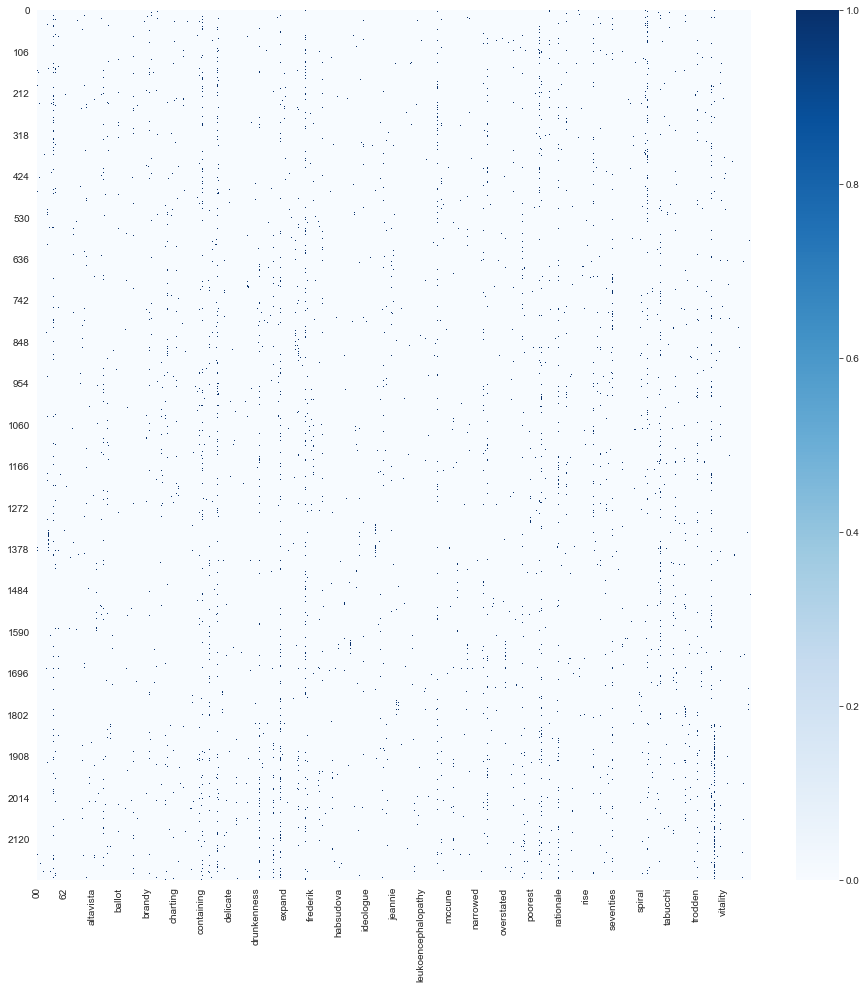

In [76]:
# Visualize Doc-Term Matrix
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(16, 16);

In [77]:
# Using thresholds to reduce the number of tokens
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 12789)

In [78]:
# Building a custom tokenizer for Lemmatization with spacy
nlp = spacy.load('en_core_web_sm')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc)
                if not w.is_punct | w.is_space]
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 25216)

In [79]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

from    0.702022
but     0.732135
as      0.742022
by      0.765843
at      0.792809
with    0.824719
that    0.830562
it      0.858427
say     0.881798
's      0.895730
on      0.906517
for     0.930337
have    0.971236
in      0.990562
and     0.991011
of      0.991461
a       0.992809
to      0.995056
be      0.998202
the     1.000000
dtype: float64

In [80]:
sample_docs = ['call you tomorrow', 'Call me a taxi', 'please call me... PLEASE!']

In [81]:
# Compute term frequency
vectorizer = CountVectorizer()
tf_dtm = vectorizer.fit_transform(sample_docs).todense()
tokens = vectorizer.get_feature_names()
term_frequency = pd.DataFrame(data=tf_dtm, columns=tokens)
print(term_frequency)

   call  me  please  taxi  tomorrow  you
0     1   0       0     0         1    1
1     1   1       0     1         0    0
2     1   1       2     0         0    0


In [82]:
# Compute document frequency
vectorizer = CountVectorizer(binary=True)
df_dtm = vectorizer.fit_transform(sample_docs).todense().sum(axis=0)
document_frequency = pd.DataFrame(data=df_dtm, columns=tokens)
print(document_frequency)

   call  me  please  taxi  tomorrow  you
0     3   2       1     1         1    1


In [83]:
# Compute TfIDF
tfidf = pd.DataFrame(data=tf_dtm/df_dtm, columns=tokens)
print(tfidf)

       call   me  please  taxi  tomorrow  you
0  0.333333  0.0     0.0   0.0       1.0  1.0
1  0.333333  0.5     0.0   1.0       0.0  0.0
2  0.333333  0.5     2.0   0.0       0.0  0.0


In [84]:
vect = TfidfVectorizer(smooth_idf=True, norm='l2', # squared weights sum to 1 by document
                       sublinear_tf=False,   # if True, use 1+log(tf)
                       binary=False)
print(pd.DataFrame(vect.fit_transform(sample_docs).todense(), columns=vect.get_feature_names()))

       call        me    please      taxi  tomorrow       you
0  0.385372  0.000000  0.000000  0.000000  0.652491  0.652491
1  0.425441  0.547832  0.000000  0.720333  0.000000  0.000000
2  0.266075  0.342620  0.901008  0.000000  0.000000  0.000000


In [85]:
# TfIDF with new articles
tfidf = TfidfVectorizer(stop_words='english')
dtm_tfidf = tfidf.fit_transform(docs.body)
tokens = tfidf.get_feature_names()
dtm_tfidf.shape

(2225, 28980)

In [86]:
token_freq = (pd.DataFrame({'tfidf': dtm_tfidf.sum(axis=0).A1, 'token': tokens})
              .sort_values('tfidf', ascending=False))
token_freq.head(10).append(token_freq.tail(10)).set_index('token')

,tfidf
token,
said,87.251494
mr,58.220783
year,41.982178
people,37.303707
new,34.197388
film,29.728250
government,28.792651
world,27.031199
time,26.358319


In [87]:
# Summarizing news articles using TfIDF weights
article = docs.sample(1).squeeze()
article_id = article.name
print(f'Topic:\t{article.topic.capitalize()}\n\n{article.heading}\n')
print(article.body.strip())

Topic:	Politics

'UK will stand firm on EU rebate'

Britain's Â£3bn EU rebate is not up for renegotiation at next week's European Council summit, Jack Straw said.  The foreign secretary told MPs the rebate, secured by Margaret Thatcher in 1984, was "entirely justified". New European commission president Jose Manuel Barroso has suggested the cash could be shared out among net contributors to the EU budget. Mr Straw acknowledged some countries in the newly enlarged 25 nation EU still had to "see the light" on the rebate.  But the foreign secretary told the Commons foreign affairs committee: "Our position is very clear: it is entirely justified and it is not for negotiation." He added that he did not think there would be a political price to pay for the UK's stance - Britain contributed more and received less than other EU states. The two-day European Council summit in Brussels begins on 16 December and is widely expected to mark the beginning of a lengthy negotiating period over the EU's

In [88]:
# Select most relevant tokens by tfidf value
article_tfidf = dtm_tfidf[article_id].todense().A1
article_tokens = pd.Series(article_tfidf, index=tokens)
article_tokens.sort_values(ascending=False).head(10)

eu            0.473400
budget        0.260669
rebate        0.259183
straw         0.209949
foreign       0.189604
justified     0.163030
commission    0.159896
summit        0.142667
secretary     0.137566
entirely      0.137515
dtype: float64

In [89]:
# Compare to random selection
pd.Series(article.body.split()).sample(10).tolist()

['beginning',
 'the',
 'secured',
 "don't",
 'the',
 'contributors',
 'for',
 'beginning',
 'justified',
 'and']

In [90]:
# Create Train & Test Sets - Stratified train_test_split
train_docs, test_docs = train_test_split(docs, stratify=docs.topic, test_size=50, random_state=42)
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [91]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
entertainment     9
tech              9
politics          9
Name: topic, dtype: int64

In [92]:
# Vectorize train & test sets
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english', max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.body)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178762 stored elements in Compressed Sparse Row format>

In [93]:
test_dtm = vectorizer.transform(test_docs.body)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4048 stored elements in Compressed Sparse Row format>